In [1]:
#!nvidia-smi
#using a GeForce GTX1080 Ti for reproducibility for all timing experiments

In [2]:
import torch
import torchvision
from torch import nn, optim, autograd
from torch.nn import functional as F
from torchvision import transforms
import numpy as np
from sklearn.metrics import roc_auc_score
import scipy
from utils.LB_utils import * 
from utils.load_not_MNIST import notMNIST
import os
import time
import matplotlib.pyplot as plt
from laplace import Laplace
import utils.scoring as scoring


s = 1
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda_status = torch.cuda.is_available()
print("device: ", device)
print("cuda status: ", cuda_status)

device:  cuda
cuda status:  True


# Load data

Files already downloaded and verified
Files already downloaded and verified


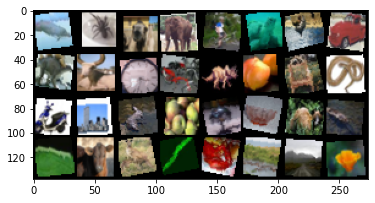

In [4]:
#load in CIFAR100
BATCH_SIZE_TRAIN_CIFAR100 = 32
BATCH_SIZE_TEST_CIFAR100 = 32

#CIFAR100_TRAIN_MEAN = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
#CIFAR100_TRAIN_STD = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    #transforms.Normalize(CIFAR100_TRAIN_MEAN, CIFAR100_TRAIN_STD),
])

transform_test = transforms.Compose([
    transforms.ToTensor()
    #transforms.Normalize(CIFAR100_TRAIN_MEAN, CIFAR100_TRAIN_STD),
])


#'~/data/cifar100'
CIFAR100_train = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=True,
                                       download=True, transform=transform_train)
CIFAR100_train_loader = torch.utils.data.DataLoader(CIFAR100_train, batch_size=BATCH_SIZE_TRAIN_CIFAR100,
                                         shuffle=True)
#'~/data/cifar100'
CIFAR100_test = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=False,
                                       download=True, transform=transform_test)
CIFAR100_test_loader = torch.utils.data.DataLoader(CIFAR100_test, batch_size=BATCH_SIZE_TEST_CIFAR100,
                                         shuffle=False)

CIFAR100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

dataiter = iter(CIFAR100_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR100/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Files already downloaded and verified


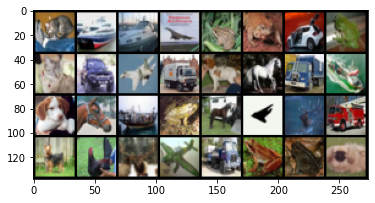

In [5]:
BATCH_SIZE_TEST_CIFAR10 = 32
#~/data/cifar10
CIFAR10_testset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False, download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_testset, batch_size=BATCH_SIZE_TEST_CIFAR10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(CIFAR10_test_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TEST_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

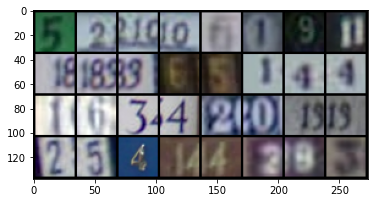

In [6]:
# load SVHN
BATCH_SIZE_TEST_SVHN = 32

#'~/data/SVHN'
test_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='test',
                             download=False, transform=transform_test)

SVHN_test_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TEST_SVHN)

dataiter = iter(SVHN_test_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TEST_SVHN/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

# Train CIFAR100 on ResNet18 (or load weights)

In [7]:
import resnet18_v2
criterion = nn.CrossEntropyLoss()
best_acc = 0.0

In [8]:
def test(net):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(CIFAR100_test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        acc = correct/total
        if acc > best_acc: 
            best_acc = acc
        

        print("test loss: ", test_loss)
        print("current acc: {}; best acc: {}".format(acc, best_acc) )

In [9]:
##### if you already have a trained model ##############
CIFAR100_PATH = 'pretrained_weights/CIFAR100_resnet18_pretrained.pt'
print("loading model from: {}".format(CIFAR100_PATH))
CIFAR100_model = resnet18_v2.ResNet18(num_classes=100).to(device)
CIFAR100_model.load_state_dict(torch.load(CIFAR100_PATH))#, map_location=torch.device('cpu')))
#test the model
test(CIFAR100_model)

loading model from: pretrained_weights/CIFAR100_resnet18_pretrained.pt
test loss:  284.88321551680565
current acc: 0.7675; best acc: 0.7675


In [10]:
targets_CIFAR100 = CIFAR100_test.targets
targets_CIFAR10 = CIFAR10_testset.targets
targets_SVHN = []
for x,y in SVHN_test_loader:
    targets_SVHN.append(y)
targets_SVHN = torch.cat(targets_SVHN).numpy()

In [11]:
num_samples = 100

# MAP estimate

In [12]:
CIFAR100_test_in_MAP = predict_MAP(CIFAR100_model, CIFAR100_test_loader, device=device).cpu().numpy()
CIFAR100_test_out_CIFAR10_MAP = predict_MAP(CIFAR100_model, CIFAR10_test_loader, device=device).cpu().numpy()
CIFAR100_test_out_SVHN_MAP = predict_MAP(CIFAR100_model, SVHN_test_loader, device=device).cpu().numpy()

In [13]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_in_MAP)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_CIFAR10_MAP)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_SVHN_MAP)).log_prob(torch.tensor(targets_SVHN)).mean().item())

0.9104677438735962
7.081529140472412
7.11580753326416


In [14]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_CIFAR100, CIFAR100_test_in_MAP))
print(scoring.expected_calibration_error(targets_CIFAR10, CIFAR100_test_out_CIFAR10_MAP))
print(scoring.expected_calibration_error(targets_SVHN, CIFAR100_test_out_SVHN_MAP))

0.05514827272727269
0.5277923232323232
0.5320773791231306


In [15]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(CIFAR100_test_in_MAP, targets_CIFAR100)
acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP = get_out_dist_values(CIFAR100_test_in_MAP, CIFAR100_test_out_CIFAR10_MAP, targets_CIFAR10)
acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP = get_out_dist_values(CIFAR100_test_in_MAP, CIFAR100_test_out_SVHN_MAP, targets_SVHN)

In [16]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP, 'CIFAR100', 'CIFAR10', 'MAP')
print_out_dist_values(acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP, 'CIFAR100', 'SVHN', 'MAP')

[In, MAP, CIFAR100] Accuracy: 0.767; average entropy: 0.777;     MMC: 0.812; Prob @ correct: 0.010
[Out-CIFAR10, MAP, CIFAR100] Accuracy: 0.005; Average entropy: 1.953;    MMC: 0.533; AUROC: 0.786; Prob @ correct: 0.010
[Out-SVHN, MAP, CIFAR100] Accuracy: 0.003; Average entropy: 2.006;    MMC: 0.535; AUROC: 0.788; Prob @ correct: 0.010


# Diagonal estimate

In [17]:
la_diag = Laplace(CIFAR100_model, 'classification', 
                     subset_of_weights='last_layer', 
                     hessian_structure='diag',
                     prior_precision=5e+1)
la_diag.fit(CIFAR100_train_loader)

In [18]:
CIFAR100_test_in_D = predict_samples(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_CIFAR10_D = predict_samples(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_SVHN_D = predict_samples(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()

time:  15.909100602999992
time:  14.689884815
time:  40.72695670499999


In [19]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_in_D)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_CIFAR10_D)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_SVHN_D)).log_prob(torch.tensor(targets_SVHN)).mean().item())

0.8943427801132202
6.66557502746582
6.712473392486572


In [20]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_CIFAR100, CIFAR100_test_in_D))
print(scoring.expected_calibration_error(targets_CIFAR10, CIFAR100_test_out_CIFAR10_D))
print(scoring.expected_calibration_error(targets_SVHN, CIFAR100_test_out_SVHN_D))

0.036703464646464616
0.47413183838383827
0.46962029294917534


In [21]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(CIFAR100_test_in_D, targets_CIFAR100)
acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D = get_out_dist_values(CIFAR100_test_in_D, CIFAR100_test_out_CIFAR10_D, targets_CIFAR10)
acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D = get_out_dist_values(CIFAR100_test_in_D, CIFAR100_test_out_SVHN_D, targets_SVHN)

In [22]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D, 'CIFAR100', 'CIFAR10', 'Diag')
print_out_dist_values(acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D, 'CIFAR100','SVHN', 'Diag')

[In, Diag, CIFAR100] Accuracy: 0.767; average entropy: 0.946;     MMC: 0.776; Prob @ correct: 0.010
[Out-CIFAR10, Diag, CIFAR100] Accuracy: 0.006; Average entropy: 1.953;    MMC: 0.480; AUROC: 0.788; Prob @ correct: 0.010
[Out-SVHN, Diag, CIFAR100] Accuracy: 0.003; Average entropy: 2.292;    MMC: 0.472; AUROC: 0.796; Prob @ correct: 0.010


# KFAC estimate

In [23]:
la_kron = Laplace(CIFAR100_model, 'classification', 
                     subset_of_weights='last_layer', 
                     hessian_structure='kron',
                     prior_precision=5e+0) 
la_kron.fit(CIFAR100_train_loader)

/home/marius/anaconda3/lib/python3.9/site-packages/laplace/utils.py:137: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180549130/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2499.)
  L, W = torch.symeig(M, eigenvectors=True)


In [24]:
CIFAR100_test_in_KFAC = predict_samples(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_CIFAR10_KFAC = predict_samples(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_SVHN_KFAC = predict_samples(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()

time:  41.649950923999995
time:  40.754340649
time:  108.68430858400001


In [25]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_in_KFAC)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_CIFAR10_KFAC)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_SVHN_KFAC)).log_prob(torch.tensor(targets_SVHN)).mean().item())

0.8889132738113403
6.709272861480713
6.738344192504883


In [26]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_CIFAR100, CIFAR100_test_in_KFAC))
print(scoring.expected_calibration_error(targets_CIFAR10, CIFAR100_test_out_CIFAR10_KFAC))
print(scoring.expected_calibration_error(targets_SVHN, CIFAR100_test_out_SVHN_KFAC))

0.03346885858585856
0.4792803232323233
0.46889069609290296


In [27]:
acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K = get_in_dist_values(CIFAR100_test_in_KFAC, targets_CIFAR100)
acc_out_CIFAR10_K, prob_correct_out_CIFAR10_K, ent_out_CIFAR10_K, MMC_out_CIFAR10_K, auroc_out_CIFAR10_K = get_out_dist_values(CIFAR100_test_in_KFAC, CIFAR100_test_out_CIFAR10_KFAC, targets_CIFAR10)
acc_out_SVHN_K, prob_correct_out_SVHN_K, ent_out_SVHN_K, MMC_out_SVHN_K, auroc_out_SVHN_K = get_out_dist_values(CIFAR100_test_in_KFAC, CIFAR100_test_out_SVHN_KFAC, targets_SVHN)

In [28]:
print_in_dist_values(acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K, 'CIFAR100', 'KFAC')
print_out_dist_values(acc_out_CIFAR10_K, prob_correct_out_CIFAR10_K, ent_out_CIFAR10, MMC_out_CIFAR10_K, auroc_out_CIFAR10_K, 'CIFAR100', 'CIFAR10', 'KFAC')
print_out_dist_values(acc_out_SVHN_K, prob_correct_out_SVHN_K, ent_out_SVHN_K, MMC_out_SVHN_K, auroc_out_SVHN_K, 'CIFAR100', 'SVHN', 'KFAC')

[In, KFAC, CIFAR100] Accuracy: 0.767; average entropy: 0.940;     MMC: 0.775; Prob @ correct: 0.010
[Out-CIFAR10, KFAC, CIFAR100] Accuracy: 0.005; Average entropy: 1.953;    MMC: 0.485; AUROC: 0.787; Prob @ correct: 0.010
[Out-SVHN, KFAC, CIFAR100] Accuracy: 0.003; Average entropy: 2.279;    MMC: 0.472; AUROC: 0.798; Prob @ correct: 0.010


# Laplace Bridge estimate

In [29]:
CIFAR100_test_in_LB_D = predict_LB(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_CIFAR10_LB_D = predict_LB(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_SVHN_LB_D = predict_LB(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()

time:  13.707837998999992
time:  13.508627709999985
time:  34.97561563200003


In [1]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_in_LB_D)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_CIFAR10_LB_D)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_SVHN_LB_D)).log_prob(torch.tensor(targets_SVHN)).mean().item())

NameError: name 'torch' is not defined

In [32]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_CIFAR100, CIFAR100_test_in_LB_D))
print(scoring.expected_calibration_error(targets_CIFAR10, CIFAR100_test_out_CIFAR10_LB_D))
print(scoring.expected_calibration_error(targets_SVHN, CIFAR100_test_out_SVHN_LB_D))

0.15056732323232322
0.23945667003367002
0.20671485328081055


In [33]:
acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB = get_in_dist_values(CIFAR100_test_in_LB_D, targets_CIFAR100)
acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB = get_out_dist_values(CIFAR100_test_in_LB_D, CIFAR100_test_out_CIFAR10_LB_D, targets_CIFAR10)
acc_out_SVHN_LB, prob_correct_out_SVHN_LB, ent_out_SVHN_LB, MMC_out_SVHN_LB, auroc_out_SVHN_LB = get_out_dist_values(CIFAR100_test_in_LB_D, CIFAR100_test_out_SVHN_LB_D, targets_SVHN)

In [34]:
print_in_dist_values(acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB, 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB, 'CIFAR100', 'CIFAR10', 'Laplace Bridge')
print_out_dist_values(acc_out_SVHN_LB, prob_correct_out_SVHN_LB, ent_out_SVHN_LB, MMC_out_SVHN_LB, auroc_out_SVHN_LB, 'CIFAR100', 'SVHN', 'Laplace Bridge')

[In, Laplace Bridge, CIFAR100] Accuracy: 0.764; average entropy: 1.901;     MMC: 0.633; Prob @ correct: 0.010
[Out-CIFAR10, Laplace Bridge, CIFAR100] Accuracy: 0.005; Average entropy: 3.715;    MMC: 0.245; AUROC: 0.791; Prob @ correct: 0.010
[Out-SVHN, Laplace Bridge, CIFAR100] Accuracy: 0.002; Average entropy: 3.911;    MMC: 0.209; AUROC: 0.815; Prob @ correct: 0.010


# LB diag norm

In [35]:
CIFAR100_test_in_LB_Dn = predict_LB_norm(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_CIFAR10_LB_Dn = predict_LB_norm(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_SVHN_LB_Dn = predict_LB_norm(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()

time:  14.728387410999972
time:  14.299690118000001
time:  43.11589264899999


In [36]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_in_LB_Dn)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_CIFAR10_LB_Dn)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_SVHN_LB_Dn)).log_prob(torch.tensor(targets_SVHN)).mean().item())

0.17095169696969692
0.8339838585858587
0.8420998068422393


In [38]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_CIFAR100, CIFAR100_test_in_LB_Dn))
print(scoring.expected_calibration_error(targets_CIFAR10, CIFAR100_test_out_CIFAR10_LB_Dn))
print(scoring.expected_calibration_error(targets_SVHN, CIFAR100_test_out_SVHN_LB_Dn))

0.17095169696969692
0.8339838585858587
0.8420998068422393


In [39]:
acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB = get_in_dist_values(CIFAR100_test_in_LB_Dn, targets_CIFAR100)
acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB = get_out_dist_values(CIFAR100_test_in_LB_Dn, CIFAR100_test_out_CIFAR10_LB_Dn, targets_CIFAR10)
acc_out_SVHN_LB, prob_correct_out_SVHN_LB, ent_out_SVHN_LB, MMC_out_SVHN_LB, auroc_out_SVHN_LB = get_out_dist_values(CIFAR100_test_in_LB_Dn, CIFAR100_test_out_SVHN_LB_Dn, targets_SVHN)

In [40]:
print_in_dist_values(acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB, 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB, 'CIFAR100', 'CIFAR10', 'Laplace Bridge')
print_out_dist_values(acc_out_SVHN_LB, prob_correct_out_SVHN_LB, ent_out_SVHN_LB, MMC_out_SVHN_LB, auroc_out_SVHN_LB, 'CIFAR100', 'SVHN', 'Laplace Bridge')

[In, Laplace Bridge, CIFAR100] Accuracy: 0.768; average entropy: 0.162;     MMC: 0.942; Prob @ correct: 0.010
[Out-CIFAR10, Laplace Bridge, CIFAR100] Accuracy: 0.006; Average entropy: 0.462;    MMC: 0.841; AUROC: 0.757; Prob @ correct: 0.010
[Out-SVHN, Laplace Bridge, CIFAR100] Accuracy: 0.003; Average entropy: 0.455;    MMC: 0.846; AUROC: 0.748; Prob @ correct: 0.010


# Laplace Bridge KFAC

In [41]:
CIFAR100_test_in_LB_K = predict_LB(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_CIFAR10_LB_K = predict_LB(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_SVHN_LB_K = predict_LB(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()

time:  39.28580208400007
time:  38.247826153000005
time:  99.67996355900004


In [42]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_in_LB_K)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_CIFAR10_LB_K)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_SVHN_LB_K)).log_prob(torch.tensor(targets_SVHN)).mean().item())

0.17990177777777777
0.20221146279117708
0.18304792158447797


In [43]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_CIFAR100, CIFAR100_test_in_LB_K))
print(scoring.expected_calibration_error(targets_CIFAR10, CIFAR100_test_out_CIFAR10_LB_K))
print(scoring.expected_calibration_error(targets_SVHN, CIFAR100_test_out_SVHN_LB_K))

0.17990177777777777
0.20221146279117708
0.18304792158447797


In [44]:
acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC = get_in_dist_values(CIFAR100_test_in_LB_K, targets_CIFAR100)
acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC = get_out_dist_values(CIFAR100_test_in_LB_K, CIFAR100_test_out_CIFAR10_LB_K, targets_CIFAR10)
acc_out_SVHN_LB_KFAC, prob_correct_out_SVHN_LB_KFAC, ent_out_SVHN_LB_KFAC, MMC_out_SVHN_LB_KFAC, auroc_out_SVHN_LB_KFAC = get_out_dist_values(CIFAR100_test_in_LB_K, CIFAR100_test_out_SVHN_LB_K, targets_SVHN)

In [45]:
print_in_dist_values(acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC, 'CIFAR100', 'LB KFAC')
print_out_dist_values(acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC, 'CIFAR10', 'LB KFAC')
print_out_dist_values(acc_out_SVHN_LB_KFAC, prob_correct_out_SVHN_LB_KFAC, ent_out_SVHN_LB_KFAC, MMC_out_SVHN_LB_KFAC, auroc_out_SVHN_LB_KFAC, 'SVHN', 'LB KFAC')

[In, LB KFAC, CIFAR100] Accuracy: 0.758; average entropy: 2.127;     MMC: 0.589; Prob @ correct: 0.010
[Out-LB KFAC, KFAC, CIFAR10] Accuracy: 0.005; Average entropy: 3.872;    MMC: 0.207; AUROC: 0.790; Prob @ correct: 0.010
[Out-LB KFAC, KFAC, SVHN] Accuracy: 0.002; Average entropy: 4.001;    MMC: 0.185; AUROC: 0.808; Prob @ correct: 0.010


# LB kfac norm

In [46]:
CIFAR100_test_in_LB_Kn = predict_LB_norm(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_CIFAR10_LB_Kn = predict_LB_norm(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_SVHN_LB_Kn = predict_LB_norm(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()

time:  15.186873312999978
time:  13.802288225999973
time:  39.77852586999995


In [47]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_in_LB_Kn)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_CIFAR10_LB_Kn)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_SVHN_LB_Kn)).log_prob(torch.tensor(targets_SVHN)).mean().item())

0.17095169696969692
0.8339838585858587
0.8420998068422393


In [48]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_CIFAR100, CIFAR100_test_in_LB_Kn))
print(scoring.expected_calibration_error(targets_CIFAR10, CIFAR100_test_out_CIFAR10_LB_Kn))
print(scoring.expected_calibration_error(targets_SVHN, CIFAR100_test_out_SVHN_LB_Kn))

0.17095169696969692
0.8339838585858587
0.8420998068422393


In [49]:
acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB = get_in_dist_values(CIFAR100_test_in_LB_Kn, targets_CIFAR100)
acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB = get_out_dist_values(CIFAR100_test_in_LB_Kn, CIFAR100_test_out_CIFAR10_LB_Kn, targets_CIFAR10)
acc_out_SVHN_LB, prob_correct_out_SVHN_LB, ent_out_SVHN_LB, MMC_out_SVHN_LB, auroc_out_SVHN_LB = get_out_dist_values(CIFAR100_test_in_LB_Kn, CIFAR100_test_out_SVHN_LB_Kn, targets_SVHN)

In [50]:
print_in_dist_values(acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC, 'CIFAR100', 'LB KFAC')
print_out_dist_values(acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC, 'CIFAR10', 'LB KFAC')
print_out_dist_values(acc_out_SVHN_LB_KFAC, prob_correct_out_SVHN_LB_KFAC, ent_out_SVHN_LB_KFAC, MMC_out_SVHN_LB_KFAC, auroc_out_SVHN_LB_KFAC, 'SVHN', 'LB KFAC')

[In, LB KFAC, CIFAR100] Accuracy: 0.758; average entropy: 2.127;     MMC: 0.589; Prob @ correct: 0.010
[Out-LB KFAC, KFAC, CIFAR10] Accuracy: 0.005; Average entropy: 3.872;    MMC: 0.207; AUROC: 0.790; Prob @ correct: 0.010
[Out-LB KFAC, KFAC, SVHN] Accuracy: 0.002; Average entropy: 4.001;    MMC: 0.185; AUROC: 0.808; Prob @ correct: 0.010


# Compare to probit approximation (extended MacKay)

In [51]:
CIFAR100_test_in_PROBIT_D = predict_probit(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_CIFAR10_PROBIT_D = predict_probit(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_SVHN_PROBIT_D = predict_probit(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()

time:  13.303066403000003
time:  13.222476190000066
time:  34.52710129299999


In [52]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_in_PROBIT_D)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_CIFAR10_PROBIT_D)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_SVHN_PROBIT_D)).log_prob(torch.tensor(targets_SVHN)).mean().item())

0.043603878787878754
0.4707173939393939
0.46496225799016605


In [53]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_CIFAR100, CIFAR100_test_in_PROBIT_D))
print(scoring.expected_calibration_error(targets_CIFAR10, CIFAR100_test_out_CIFAR10_PROBIT_D))
print(scoring.expected_calibration_error(targets_SVHN, CIFAR100_test_out_SVHN_PROBIT_D))

0.043603878787878754
0.4707173939393939
0.46496225799016605


In [54]:
acc_in_PROBIT, prob_correct_in_PROBIT, ent_in_PROBIT, MMC_in_PROBIT = get_in_dist_values(CIFAR100_test_in_PROBIT_D, targets_CIFAR100)
acc_out_CIFAR10_PROBIT, prob_correct_out_CIFAR10_PROBIT, ent_out_CIFAR10_PROBIT, MMC_out_CIFAR10_PROBIT, auroc_out_CIFAR10_PROBIT = get_out_dist_values(CIFAR100_test_in_PROBIT_D, CIFAR100_test_out_CIFAR10_PROBIT_D, targets_CIFAR10)
acc_out_SVHN_PROBIT, prob_correct_out_SVHN_PROBIT, ent_out_SVHN_PROBIT, MMC_out_SVHN_PROBIT, auroc_out_SVHN_PROBIT = get_out_dist_values(CIFAR100_test_in_PROBIT_D, CIFAR100_test_out_SVHN_PROBIT_D, targets_SVHN)

In [55]:
print_in_dist_values(acc_in_PROBIT, prob_correct_in_PROBIT, ent_in_PROBIT, MMC_in_PROBIT, 'CIFAR100', 'PROBIT')
print_out_dist_values(acc_out_CIFAR10_PROBIT, prob_correct_out_CIFAR10_PROBIT, ent_out_CIFAR10_PROBIT, MMC_out_CIFAR10_PROBIT, auroc_out_CIFAR10_PROBIT, 'CIFAR100', 'CIFAR10', 'PROBIT')
print_out_dist_values(acc_out_SVHN_PROBIT, prob_correct_out_SVHN_PROBIT, ent_out_SVHN_PROBIT, MMC_out_SVHN_PROBIT, auroc_out_SVHN_PROBIT, 'CIFAR100', 'SVHN', 'PROBIT')

[In, PROBIT, CIFAR100] Accuracy: 0.766; average entropy: 0.982;     MMC: 0.778; Prob @ correct: 0.010
[Out-CIFAR10, PROBIT, CIFAR100] Accuracy: 0.006; Average entropy: 2.295;    MMC: 0.476; AUROC: 0.789; Prob @ correct: 0.010
[Out-SVHN, PROBIT, CIFAR100] Accuracy: 0.003; Average entropy: 2.415;    MMC: 0.468; AUROC: 0.795; Prob @ correct: 0.010


### Probit KFAC

In [56]:
CIFAR100_test_in_PROBIT_K = predict_probit(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_CIFAR10_PROBIT_K = predict_probit(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_SVHN_PROBIT_K = predict_probit(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()

time:  38.30571304599994
time:  38.30010607899999
time:  99.95880420900005


In [57]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_in_PROBIT_K)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_CIFAR10_PROBIT_K)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(CIFAR100_test_out_SVHN_PROBIT_K)).log_prob(torch.tensor(targets_SVHN)).mean().item())

0.03239659595959593
0.44857138383838385
0.43862158869736084


In [58]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_CIFAR100, CIFAR100_test_in_PROBIT_K))
print(scoring.expected_calibration_error(targets_CIFAR10, CIFAR100_test_out_CIFAR10_PROBIT_K))
print(scoring.expected_calibration_error(targets_SVHN, CIFAR100_test_out_SVHN_PROBIT_K))

0.03239659595959593
0.44857138383838385
0.43862158869736084


In [59]:
acc_in_PROBIT, prob_correct_in_PROBIT, ent_in_PROBIT, MMC_in_PROBIT = get_in_dist_values(CIFAR100_test_in_PROBIT_K, targets_CIFAR100)
acc_out_CIFAR10_PROBIT, prob_correct_out_CIFAR10_PROBIT, ent_out_CIFAR10_PROBIT, MMC_out_CIFAR10_PROBIT, auroc_out_CIFAR10_PROBIT = get_out_dist_values(CIFAR100_test_in_PROBIT_K, CIFAR100_test_out_CIFAR10_PROBIT_K, targets_CIFAR10)
acc_out_SVHN_PROBIT, prob_correct_out_SVHN_PROBIT, ent_out_SVHN_PROBIT, MMC_out_SVHN_PROBIT, auroc_out_SVHN_PROBIT = get_out_dist_values(CIFAR100_test_in_PROBIT_K, CIFAR100_test_out_SVHN_PROBIT_K, targets_SVHN)

In [60]:
print_in_dist_values(acc_in_PROBIT, prob_correct_in_PROBIT, ent_in_PROBIT, MMC_in_PROBIT, 'CIFAR100', 'PROBIT')
print_out_dist_values(acc_out_CIFAR10_PROBIT, prob_correct_out_CIFAR10_PROBIT, ent_out_CIFAR10_PROBIT, MMC_out_CIFAR10_PROBIT, auroc_out_CIFAR10_PROBIT, 'CIFAR100', 'CIFAR10', 'PROBIT')
print_out_dist_values(acc_out_SVHN_PROBIT, prob_correct_out_SVHN_PROBIT, ent_out_SVHN_PROBIT, MMC_out_SVHN_PROBIT, auroc_out_SVHN_PROBIT, 'CIFAR100', 'SVHN', 'PROBIT')

[In, PROBIT, CIFAR100] Accuracy: 0.766; average entropy: 1.107;     MMC: 0.755; Prob @ correct: 0.010
[Out-CIFAR10, PROBIT, CIFAR100] Accuracy: 0.006; Average entropy: 2.400;    MMC: 0.454; AUROC: 0.788; Prob @ correct: 0.010
[Out-SVHN, PROBIT, CIFAR100] Accuracy: 0.002; Average entropy: 2.554;    MMC: 0.441; AUROC: 0.796; Prob @ correct: 0.010


In [ ]:
break

# Compare to Second-order Delta Posterior Predictive

In [ ]:
CIFAR100_test_in_SODPP_D = predict_second_order_dpp(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_CIFAR10_SODPP_D = predict_second_order_dpp(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_SVHN_SODPP_D = predict_second_order_dpp(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()

In [ ]:
acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP = get_in_dist_values(CIFAR100_test_in_SODPP_D, targets_CIFAR100)
acc_out_CIFAR10_SODPP, prob_correct_out_CIFAR10_SODPP, ent_out_CIFAR10_SODPP, MMC_out_CIFAR10_SODPP, auroc_out_CIFAR10_SODPP = get_out_dist_values(CIFAR100_test_in_SODPP_D, CIFAR100_test_out_CIFAR10_SODPP_D, targets_CIFAR10)
acc_out_SVHN_SODPP, prob_correct_out_SVHN_SODPP, ent_out_SVHN_SODPP, MMC_out_SVHN_SODPP, auroc_out_SVHN_SODPP = get_out_dist_values(CIFAR100_test_in_SODPP_D, CIFAR100_test_out_SVHN_SODPP_D, targets_SVHN)

In [ ]:
print_in_dist_values(acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP, 'CIFAR100', 'SODPP')
print_out_dist_values(acc_out_CIFAR10_SODPP, prob_correct_out_CIFAR10_SODPP, ent_out_CIFAR10_SODPP, MMC_out_CIFAR10_SODPP, auroc_out_CIFAR10_SODPP, 'CIFAR100', 'CIFAR10', 'SODPP')
print_out_dist_values(acc_out_SVHN_SODPP, prob_correct_out_SVHN_SODPP, ent_out_SVHN_SODPP, MMC_out_SVHN_SODPP, auroc_out_SVHN_SODPP, 'CIFAR100', 'SVHN', 'SODPP')

### SODPP KFAC

In [ ]:
CIFAR100_test_in_SODPP_K = predict_second_order_dpp(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_CIFAR10_SODPP_K = predict_second_order_dpp(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR100_test_out_SVHN_SODPP_K = predict_second_order_dpp(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()

In [ ]:
acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP = get_in_dist_values(CIFAR100_test_in_SODPP_K, targets_CIFAR100)
acc_out_CIFAR10_SODPP, prob_correct_out_CIFAR10_SODPP, ent_out_CIFAR10_SODPP, MMC_out_CIFAR10_SODPP, auroc_out_CIFAR10_SODPP = get_out_dist_values(CIFAR100_test_in_SODPP_K, CIFAR100_test_out_CIFAR10_SODPP_K, targets_CIFAR10)
acc_out_SVHN_SODPP, prob_correct_out_SVHN_SODPP, ent_out_SVHN_SODPP, MMC_out_SVHN_SODPP, auroc_out_SVHN_SODPP = get_out_dist_values(CIFAR100_test_in_SODPP_K, CIFAR100_test_out_SVHN_SODPP_K, targets_SVHN)

In [ ]:
print_in_dist_values(acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP, 'CIFAR100', 'SODPP')
print_out_dist_values(acc_out_CIFAR10_SODPP, prob_correct_out_CIFAR10_SODPP, ent_out_CIFAR10_SODPP, MMC_out_CIFAR10_SODPP, auroc_out_CIFAR10_SODPP, 'CIFAR100', 'CIFAR10', 'SODPP')
print_out_dist_values(acc_out_SVHN_SODPP, prob_correct_out_SVHN_SODPP, ent_out_SVHN_SODPP, MMC_out_SVHN_SODPP, auroc_out_SVHN_SODPP, 'CIFAR100', 'SVHN', 'SODPP')